In [2]:
import pandas as pd
import numpy as np

import sys
sys.path.append('..')
from src.utils import preprocess_cscid
from src.data import read_data, setup_paths
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

# read full data
paths = setup_paths()
df_full = pd.read_parquet(os.path.join(paths['out_data'], 'nway_csc21_gaia3_full.parquet'))

# get basic matches (positives and negatives)
separation_threshold = 1.3 
range_offaxis = '0-3'

# get positive cases (highest p_i per source) 
df_pos = df_full.loc[df_full.groupby('csc21_name')['p_i'].idxmax()]
df_pos = df_pos[df_pos['separation'] <= separation_threshold]

# get negative cases (lowest p_i per source)
df_pos_comp = df_full[~df_full.index.isin(df_pos.index)]
df_neg = df_pos_comp.loc[df_pos_comp.groupby('csc21_name')['p_i'].idxmin()]

# split chandra ids into train/val splits
cscids = df_pos.csc21_name.unique()
cscids_train, cscids_val = train_test_split(cscids, test_size=0.2, random_state=42)

df_analysis = pd.concat([df_pos, df_neg])

# create train/val sets
train_set = df_analysis[df_analysis['csc21_name'].isin(cscids_train)]
val_set = df_analysis[df_analysis['csc21_name'].isin(cscids_val)]


In [4]:
dw_df = pd.read_parquet('../data/nway_CSC21_GAIA3.parquet', engine='fastparquet')

In [15]:
dw_df.columns

Index(['ENS', 'CSC21_CSCID', 'CSC21_RA', 'CSC21_Dec', 'CSC21_Errmaj',
       'CSC21_Errmin', 'CSC21_ErrPA', 'GAIA3_source_id', 'GAIA3_ra',
       'GAIA3_dec', 'GAIA3_era', 'GAIA3_edec', 'GAIA3_epa',
       'GAIA3_phot_g_mean_mag', 'GAIA3_phot_bp_mean_mag',
       'GAIA3_phot_rp_mean_mag', 'GAIA3_bp_rp', 'GAIA3_bp_g', 'GAIA3_g_rp',
       'GAIA3_parallax', 'GAIA3_parallax_over_error', 'GAIA3_pmra',
       'GAIA3_pmdec', 'Separation_GAIA3_CSC21', 'Separation_GAIA3_CSC21_ra',
       'Separation_GAIA3_CSC21_dec', 'Separation_max', 'ncat',
       'dist_bayesfactor', 'dist_post', 'p_single', 'p_any', 'p_i',
       'match_flag', 'EPOS1', 'EPOS2', 'EPOS', 'SEP_EPOS'],
      dtype='object')

In [12]:
dw_df[['CSC21_ErrPA', 'EPOS']].sample(10).to_latex()

'\\begin{tabular}{lrr}\n\\toprule\n & CSC21_ErrPA & EPOS \\\\\n\\midrule\n991828 & 0.000000 & 0.910955 \\\\\n1717130 & 178.500000 & 0.842927 \\\\\n426229 & 0.000000 & 0.584155 \\\\\n1656807 & 125.199997 & 0.191299 \\\\\n1261313 & 51.700001 & 0.158476 \\\\\n2061368 & 176.600006 & 0.822963 \\\\\n2042575 & 99.900002 & 0.154368 \\\\\n65430 & 101.000000 & 0.209895 \\\\\n1353306 & 22.600000 & 0.225713 \\\\\n2265980 & 98.300003 & 0.140918 \\\\\n\\bottomrule\n\\end{tabular}\n'

Correlation: 0.9983713553294333


Text(0, 0.5, 'Combined error from major/minor axes (arcsec)')

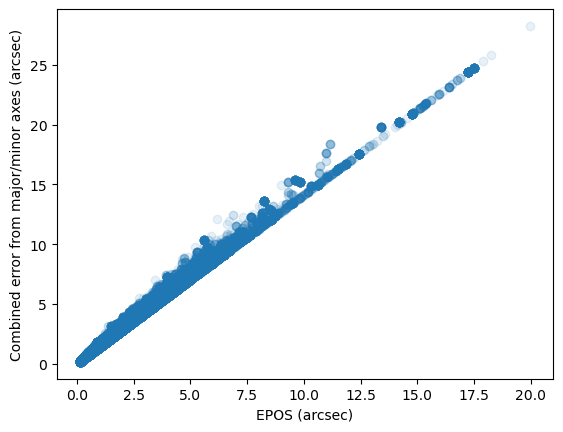

In [17]:
# compute total position error from major/minor axes
total_pos_err = np.sqrt(dw_df['CSC21_Errmaj']**2 + dw_df['CSC21_Errmin']**2)

# compare with EPOS
print("Correlation:", np.corrcoef(dw_df['EPOS'], total_pos_err)[0,1])
# plot them
plt.scatter(dw_df['EPOS'], total_pos_err, alpha=0.1)
plt.xlabel('EPOS (arcsec)')  
plt.ylabel('Combined error from major/minor axes (arcsec)')

Ratios with EPOS:
Geometric mean: 1.0000007743192627
Arithmetic mean: 0.9935916408799528
Quadrature: 0.6980629888238539


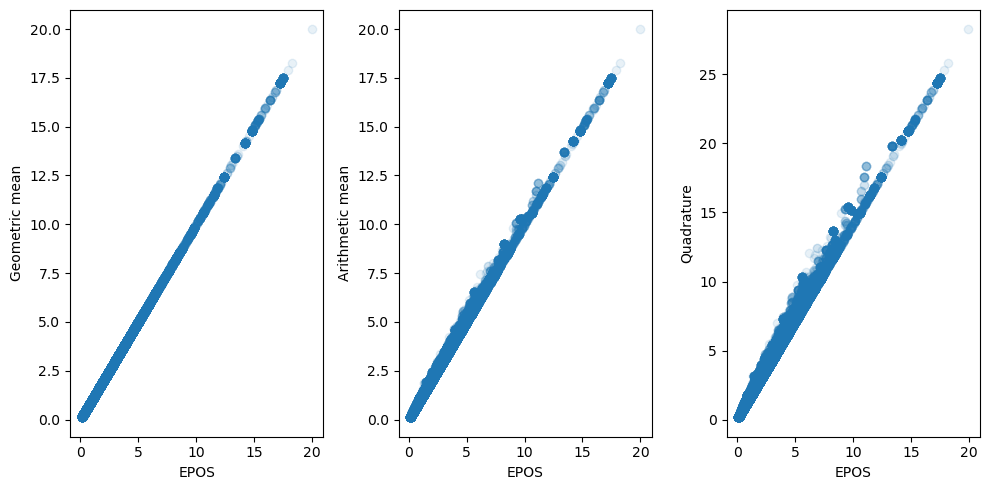

In [18]:
# try different error combinations
geom_mean = np.sqrt((dw_df['CSC21_Errmaj'] * dw_df['CSC21_Errmin'])) 
arith_mean = (dw_df['CSC21_Errmaj'] + dw_df['CSC21_Errmin'])/2
quadrature = np.sqrt(dw_df['CSC21_Errmaj']**2 + dw_df['CSC21_Errmin']**2)

print("Ratios with EPOS:")
print("Geometric mean:", np.median(dw_df['EPOS']/geom_mean))
print("Arithmetic mean:", np.median(dw_df['EPOS']/arith_mean)) 
print("Quadrature:", np.median(dw_df['EPOS']/quadrature))

# plot all vs EPOS
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.scatter(dw_df['EPOS'], geom_mean, alpha=0.1)
plt.xlabel('EPOS')
plt.ylabel('Geometric mean') 

plt.subplot(132)
plt.scatter(dw_df['EPOS'], arith_mean, alpha=0.1)
plt.xlabel('EPOS')
plt.ylabel('Arithmetic mean')

plt.subplot(133)
plt.scatter(dw_df['EPOS'], quadrature, alpha=0.1)
plt.xlabel('EPOS') 
plt.ylabel('Quadrature')

plt.tight_layout()

In [5]:
df_full.columns

Index(['csc21_name', 'csc21_ra', 'csc21_dec', 'csc21_errmaj', 'csc21_errmin',
       'csc21_errpa', 'hard_hs', 'hard_hm', 'hard_hm_lolim', 'hard_hm_hilim',
       'hard_ms', 'hard_ms_lolim', 'hard_ms_hilim', 'var_intra_prob_b',
       'var_intra_index_b', 'var_inter_prob_b', 'var_inter_index_b',
       'var_inter_sigma_b', 'extent_flag', 'pileup_flag', 'var_flag',
       'src_area_b', 'photflux_aper_b', 'photflux_aper_hilim_b',
       'photflux_aper_lolim_b', 'acis_time', 'min_theta_mean',
       'yangetal_gcs_class', 'yangetal_training_class', 'perezdiazetal_class',
       'gaia3_source_id', 'gaia3_ra', 'gaia3_dec', 'gaia3_era', 'gaia3_edec',
       'gaia3_epa', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
       'bp_rp', 'bp_g', 'g_rp', 'parallax', 'parallax_error',
       'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error',
       'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_bp_mean_flux',
       'phot_bp_mean_flux_error', 'phot_rp_mean_flux',
  

In [6]:
import numpy as np

def verify_error_ellipse(ra, dec, errpa, errmaj, errmin):
    """verify error ellipse params match with conversion formulas"""
    # convert degrees to radians
    phi = (errpa - 90) / 180 * np.pi
    
    # squared terms
    a2 = errmaj**2 
    b2 = errmin**2
    s = np.sin(phi)
    c = np.cos(phi) 
    s2 = s**2
    c2 = c**2
    
    # formulas from bayesdistance.py
    sigma_x = np.sqrt(a2 * s2 + b2 * c2)
    sigma_y = np.sqrt(a2 * c2 + b2 * s2)
    rho = c * s * (a2 - b2) / (sigma_x * sigma_y)
    
    return sigma_x, sigma_y, rho

# test with a few rows from your dataframe
test_rows = df.head()
for _, row in test_rows.iterrows():
    # Chandra
    sx1, sy1, rho1 = verify_error_ellipse(
        row.csc21_ra, row.csc21_dec, 
        row.csc21_errpa, row.csc21_errmaj, row.csc21_errmin
    )
    # Gaia 
    sx2, sy2, rho2 = verify_error_ellipse(
        row.gaia3_ra, row.gaia3_dec,
        row.gaia3_epa, row.gaia3_era, row.gaia3_edec
    )
    print(f"Chandra: {sx1:.3f}, {sy1:.3f}, {rho1:.3f}")
    print(f"Gaia: {sx2:.3f}, {sy2:.3f}, {rho2:.3f}")

NameError: name 'df' is not defined